# Chapter 3, RV Generation

## Part 1, Generation of uniform(0,1)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
np.random.uniform()

0.3342821905590023

pseudorandom numbers appear random but are actually from a deterministic sequence

In [3]:
np.random.uniform()

0.4791901419057564

Linear Congruential Generator. See: https://en.wikipedia.org/wiki/Linear_congruential_generator

Uniform (discrete on) $\{0,1,2,\ldots,2^{32}-1\}$

In [4]:
a = 1664525;
c = 1013904223;
m = 2**32;

$$
x_{n+1} = a x_n+c~~ \text{mod}~~ m
$$

Seed: $x_0$.

In [5]:
class LCG:
    def __init__(self, seed: int, a: int, c: int, m: int):
        self.X = seed
        self.a = a
        self.c = c
        self.m = m

    def next(self):
        self.X = (self.a * self.X + self.c) % self.m
        return self.X

    def random(self):
        return self.next()/self.m

In [6]:
lcg = LCG(seed = 42, a = 1664525, c = 1013904223, m = 2**32)

In [7]:
lcg.next()

1083814273

In [8]:
lcg.next()

378494188

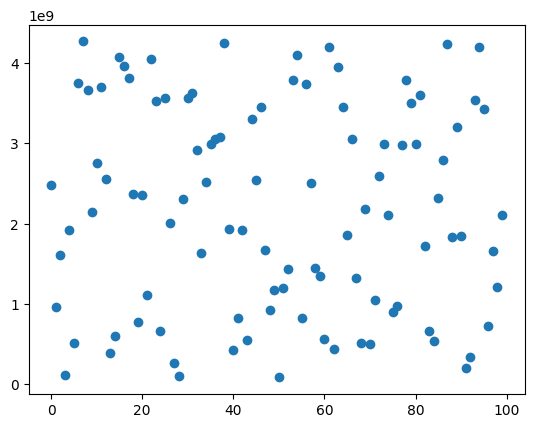

In [9]:
plt.scatter(range(100), [lcg.next() for _ in range(100)]);

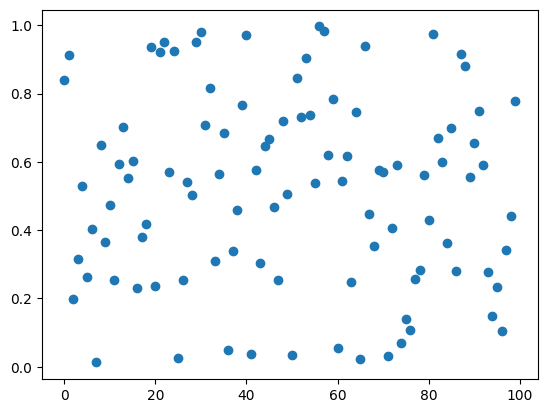

In [10]:
plt.scatter(range(100), [lcg.next()/(2**32) for _ in range(100)]);

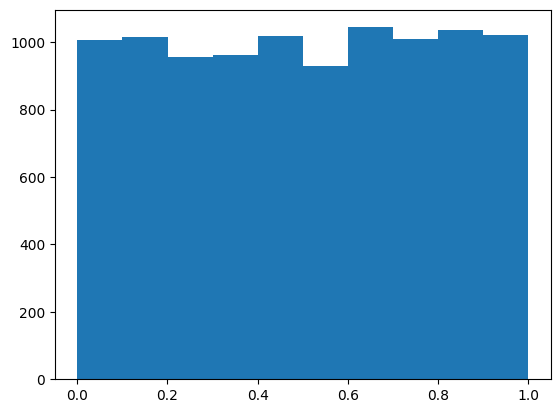

In [11]:
plt.hist([lcg.next()/(2**32) for _ in range(10**4)]);

## Part 2 (the main part), generation of everything else

## Inverse Probability Transform


You want to generate a random variable $X$ from a distribution that has CDF $F_X(x)$.

What you do is take $U \sim \text{uniform}(0,1)$.  And then you set $X = F_X^{-1}(U)$.

E.g. 

$$
F_X(x) = 
\begin{cases}
0 & \text{for}\quad x < 0\\
1-e^{-\lambda x} & \text{for} \quad x \ge 0
\end{cases}
$$

We saw before $F^{-1}_X(u) = -\frac{1}{\lambda}\log(1-u)$.  

In [12]:
# Wolrd made
# uni_rv = np.random.rand

# Home made
uni_rv = lcg.random 

In [13]:
def exp_rv(lam = 1.0):
    return -(1/lam)*math.log(uni_rv()) # did not do 1-lcg.random() because not needed

In [14]:
exp_rv()

1.7501536025965556

In [15]:
my_exps = [exp_rv(lam =1.5) for _ in range(10**4)]

In [16]:
def exp_pdf(x, lam = 1.0):
    if x >= 0:
        return lam * math.exp(-lam*x)
    return 0 #else

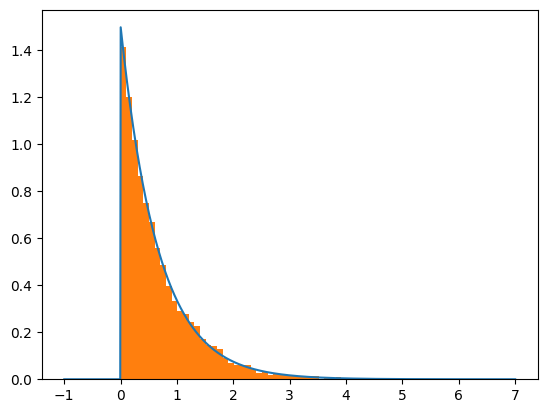

In [17]:
x_vals = np.linspace(-1, 7, 1000)
pdf_vals = [exp_pdf(x, lam = 1.5) for x in x_vals]
plt.plot(x_vals,pdf_vals)
plt.hist(my_exps, bins = 50, density = True);

# Acceptance Rejection Sampling

We want to generate from $f(x)$. It is hard.

We have a way to generate from $g(x)$ and it is easier.

Support of $g$ is at least as large as support of $f$.

We pick $C$ such that $f(x) \le C g(x)$ for all $x$.

Algorithm:
1. Generate X from $g(x)$.
2. Generate U, uniform(0,1).
3. Ouput X if $U \le \frac{f(X)}{Cg(X)}$  (Accepting).
   Otherwise (i.e. if $U > \frac{f(x)}{Cg(x)}$) return to step 1 (Rejecting).

In [18]:
def acccept_reject_rv(f, g, g_rv, C):
    while True:
        X = g_rv()
        U = uni_rv()
        if U <= f(X)/(C*g(X)):
            return X

Example on exp(1) truncated at $1$.

$$
f(x) = \frac{1}{1-e^{-1}} e^{-x}
$$
for $x \in [0,1]$ and $0$ otherwise

In [19]:
def target_exp_f(x):
    if x<0 or x>1:
        return 0.0 #added after lecture
    return math.exp(-x)/(1-1/math.e)

In [20]:
sum([target_exp_f(x)*0.001 for x in np.arange(0,1,0.001)]) #This is just a rough numerical check to see it is a valid pdf.

1.0005000833333333

# To continue here...

$$
\frac{f(x)}{g(x)} \le C
\qquad \forall x
$$

Can choose $C = \sup \{  x ~:~ \frac{f(x)}{g(x)} \}$

(or $\max$ if exists). This will be the lowest possible $C$ and maximize the probability of acceptance.

Let's do something boring, have the proposal as a uniform(0,1)

In [21]:
def proposal_uni_f(x):
    if x>=0 and x<=1:
        return 1.0
    else:
        return 0.0

In [22]:
# Knowing the shape of the distributions, let's choose C as the maximal of the target
C = target_exp_f(0)
C

1.5819767068693265

In [23]:
acccept_reject_rv(target_exp_f, proposal_uni_f, uni_rv, C)

0.15129186818376184

In [24]:
data = [acccept_reject_rv(target_exp_f, proposal_uni_f, uni_rv, C) for _ in range(10**5)]
# plt.hist(data, bins = 50, density = True);

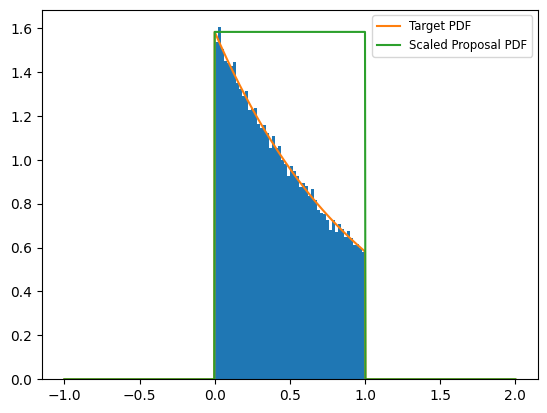

In [25]:
# data = [acccept_reject_rv(target_exp_f, proposal_uni_f, uni_rv, C) for _ in range(10**5)]
plt.hist(data, bins = 50, density = True)
x_vals = np.linspace(-1, 2, 1000)
pdf_vals = [target_exp_f(x) for x in x_vals]
scaled_proposal_vals = [C*proposal_uni_f(x) for x in x_vals]
plt.plot(x_vals, pdf_vals, label = "Target PDF")
plt.plot(x_vals, scaled_proposal_vals, label = "Scaled Proposal PDF")
plt.legend(loc='upper right', fontsize='small')
plt.show()

# A different approach to generation: Transforms

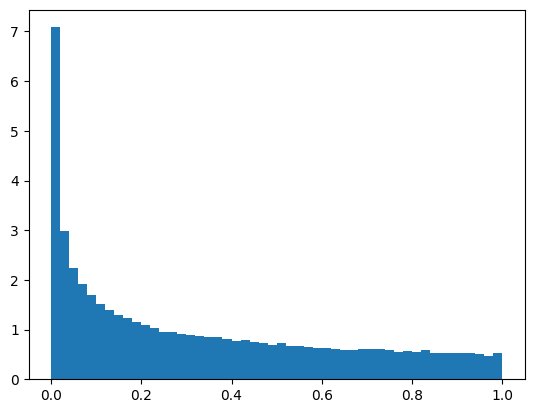

In [26]:
data = [uni_rv()**2 for _ in range(10**5)]
plt.hist(data,density=True,bins=50);

https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform

In [27]:
def rv_normal_box_muller():
    return math.sqrt(-2*math.log(uni_rv())) * math.cos(2*math.pi*uni_rv())

In [28]:
rv_normal_box_muller()

1.053368001186133

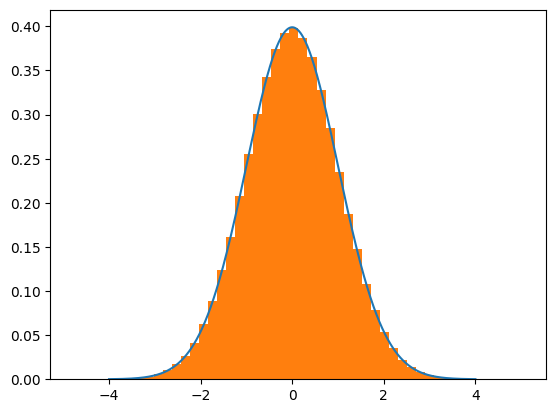

In [29]:
data = [rv_normal_box_muller() for _ in range(10**6)]
x_vals = np.linspace(-4, 4, 1000)
pdf_vals = [(2*math.pi)**-0.5 * math.exp(-x*x/2) for x in x_vals]
plt.plot(x_vals, pdf_vals)
plt.hist(data, bins = 50, density = True);

For the fun, let's use this for accept-reject

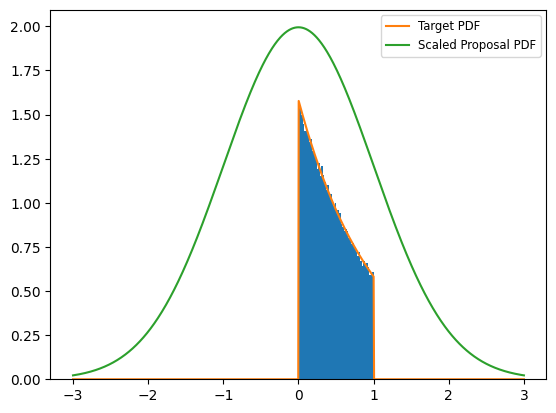

In [30]:
C = 5
data = [acccept_reject_rv(target_exp_f, 
                          lambda x: (2*math.pi)**-0.5 * math.exp(-x*x/2), 
                          rv_normal_box_muller, 
                          C) for _ in range(10**5)]
plt.hist(data, bins = 50, density = True)
x_vals = np.linspace(-3, 3, 1000)
pdf_vals = [target_exp_f(x) for x in x_vals]
scaled_proposal_vals = [C*(2*math.pi)**-0.5 * math.exp(-x*x/2) for x in x_vals]
plt.plot(x_vals, pdf_vals, label = "Target PDF")
plt.plot(x_vals, scaled_proposal_vals, label = "Scaled Proposal PDF")
plt.legend(loc='upper right', fontsize='small')
plt.show()

# Sampling discrete distributions

In [31]:
probs = [1/3, 1/6, 1/6, 1/12, 3/12];

In [32]:
sum(probs)

1.0

In [33]:
def sample(probs):
    u = np.random.rand()
    n = 0
    total = 0.0
    while True:
        total += probs[n]
        if u <= total:
            return n
        n+=1

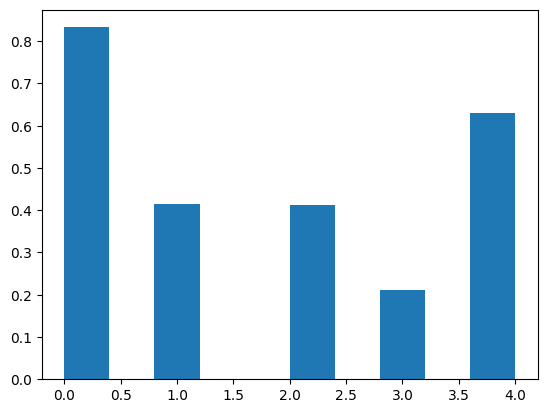

In [34]:
data = [sample(probs) for _ in range(10**5)]
plt.hist(data, density = True);